# Notes (deleted before hand in)

- Should the Grid Search be included in this code?

# Final notebook with all code gathered 
*Be aware that some of the codeblocks will return files to be stored - This will be clear before the block*

# Table of contents
0. Imports
1. Reading data
2. Making synthetic data
3. Making training data
4. Multinomial Naive Bayes
5. Convolutional Neural Network
6. Heatmaps

# 0. Imports

In [ ]:
import gzip
import json
import random
import time
from nltk import word_tokenize
from tqdm import tqdm
import contractions
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re

# Imports for the synonym dictionary 
import requests
from bs4 import BeautifulSoup
from nltk.wsd import lesk

#wordnet imports
#importing NLTK corpus synonym dictionary, pos-tagging and checking the outputs
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
import random
from sklearn.pipeline import Pipeline

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

#Word2Vec imports
import gensim.models

#wordnet downloads
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

random.seed(42)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Reading data

In [ ]:
#here
def reading_in(path):
    thing=[]
    for line in gzip.open(path):
        review_data = json.loads(line)
        subthing = dict()
        for key in review_data:
            subthing[key]= review_data[key]
        thing.append(subthing)
    return thing

In [ ]:
train = reading_in('../data/classification/music_reviews_train.json.gz')
dev = reading_in('../data/classification/music_reviews_dev.json.gz') # do not use!
#test = reading_in('../data/classification/music_reviews_test_masked.json.gz') #do not use!
train = shuffle(train, random_state=42)

In [ ]:
train_x = [i['reviewText'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]
train_y =  [i['sentiment'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]

dev_x = [i['reviewText'] if "reviewText" in i.keys() else "" for i in dev]
dev_y = [i['sentiment'] for i in dev]

Positive and negative not balanced

<BarContainer object of 2 artists>

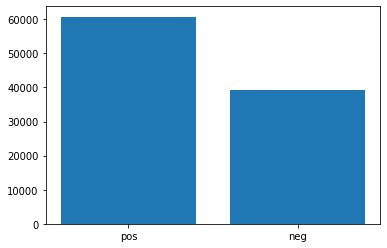

In [ ]:
pos_neg = [sum([i =="positive" for i in train_y]),sum([i != "positive" for i in train_y])]

plt.bar(x=["pos","neg"], height = pos_neg) 

Balancing the training data

In [ ]:
###split into pos and neg
train_x_pos = []
train_x_neg = []
train_y_pos = []
train_y_neg = []
for i in range(len(train_x)):
    if train_y[i] == "positive":
        train_x_pos.append(train_x[i])
        train_y_pos.append(train_y[i])
    else:
        train_x_neg.append(train_x[i])
        train_y_neg.append(train_y[i])
train_x_neg.extend(train_x_pos[0:len(train_x_neg)])
train_y_neg.extend(train_y_pos[0:len(train_y_neg)])
balanced_x_train_s = train_x_neg
balanced_y_train_s = train_y_neg

balanced_x_train, balanced_y_train = shuffle(balanced_x_train_s, balanced_y_train_s, random_state= 42)


# 1. Making synthetic data

Starting with initializing a simple tokenizer to split the words in the dataset such that the DAMs have words and not sentences to work at.

In [ ]:
def tokenize_corpus(corpus):
    return [word_tokenize(contractions.fix(s)) for s in corpus]

In [ ]:
train_x_split = tokenize_corpus(balanced_x_train)

## WebScrape Synonym replacement

In [ ]:
##Alternative to PyDictionary
##THIS IS COPIED FROM SLACK
# https://stackoverflow.com/questions/52910297/pydictionary-word-has-no-synonyms-in-the-api

def webscrape(term):
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})] # 'css-1gyuw4i eh475bn0' for less relevant synonyms


Function that replaces words with the synonym found by the webscrape above

In [ ]:
dont_replace = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will','I ', 'it ', 'she ', 'sie ', 'they ', 've ', 'xe ', 'you ', 'ze ', 'zie ','he',"you","we","mine","hers","his","yours","its","ours","theirs","your","our","oneself","oneselves","yourself","yourselves","himself","herself","himself","myself","themselves","itself","ourselves","ourself","us","them"] #Used to avoid changing function and pronouns words
def gen_synth_web(sentence,prob = 0.5):
    new_sen = []
    for word in sentence:
        if word in dont_replace:
            new_sen.append(word)
        else:
            threshold = random.random()
            if prob > threshold:
                #print(threshold) can remove later kept for debugging
                syn = webscrape(word)
                if len(syn) != 0:
                    #print("selected", word) can remove later kept for debugging
                    new_sen.append(random.choice(syn))
                else:new_sen.append(word)
            else:
                new_sen.append(word)
    return new_sen

Small example sentence

In [ ]:
print(train_x_split[3])
print('Synonym replaced:',gen_synth_web(train_x_split[3]) )

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
Synonym replaced: ['I', 'embrace ', 'every ', 'sound', 'of', 'all ', 'George', 'Ezra', 'sings', 'in', ';', 'impressive ', 'young', 'father ', '.']


The below code block does data augmentation with the above WebScrape. Set run = True to run the code - Not recommended as it will take some time because of the limiter on the scrapes per second

In [ ]:
run = False
if run:
    for i in tqdm(train_x_split[:1000]):#running with 0:1000 dont uncomment as will mess up file 
        with open ("../data/synthetic1.txt","a") as f:
            f.write(' '.join(gen_synth_web(i))+"\n")
            time.sleep(3)

## Wordnet



In [ ]:
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
wordnet_tag_map = {'NN': ['n'],'NNS': ['n'],'JJ': ['a'],'JJR': ['a'],'JJS': ['a'],'RB': ['r'],'RBR': ['r'],'RBS': ['r'], 'VB': ['v'], 'VBG': ['v'], 'VBD': ['v'], 'VBN': ['v'], 'VBP': ['v'], 'VBZ': ['v']} #Making pos-tags coincide
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_wordnet(sentence):
    sentence = nltk.pos_tag(sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if random.random()>0.5:
            if word[1] in relevant and word[0] not in aux_verbs: #Not changing functional words
                tag = wordnet_tag_map[word[1]]
                chosen = lesk(sentence, word[0], tag[0]) #from all synsets choose the most likely in a smart way, thanks to library!
                if chosen is None:
                    new_sentence.append(word[0]) #sometimes no synset is chosen so we just give the new sentence the original word
                else:
                    options = chosen.lemma_names()
                    if word[0] in options:
                        options.remove(word[0])
                    if len(options)>0:
                        chosen_w = random.choice(options)
                        if "_" in chosen_w:
                            for w in chosen_w.split("_"):
                                new_sentence.append(w)
                        else:
                            new_sentence.append(chosen_w)
                    else:
                        new_sentence.append(word[0])
            else:
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

Small example sentence

In [ ]:
print(train_x_split[3])
print('Synonym replaced:',change_wordnet(train_x_split[3]))

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
Synonym replaced: ['I', 'eff', 'the', 'strait', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']


The below code block does data augmentation with the above WordNet. Set run = True to run the code - Not recommended as it will take some time and write to a file

In [ ]:
run = False
if run:
    wn_x_train = [change_wordnet(i) for i in train_x_split]
    with open("../data/synthetic/wordnet.csv",'w') as f:
        f.writelines('\t'.join(s) + '\n' for s in wn_x_train)

## Word2Vec
Loading the Google embeddings

In [ ]:
gooEmbs = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-50k.bin', binary=True)
print('loading finished')

loading finished


In [ ]:
# With a threshold and without the check of same word
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_word2vec(original_sentence, prob = 0.5, threshold = .6):
    sentence = nltk.pos_tag(original_sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if word[1] in relevant and word[0] not in aux_verbs:
            if random.random() > prob:
                try:
                    syno = gooEmbs.most_similar(word[0]) #taking the most similar word from word2vec
                    syno_pos = []
                    # method 1: 
                    for s in syno:
                        if s[1] > threshold:
                            syno_pos.append(s)
                        else: 
                            break # because all the words are sorted we know that if one word is under 60% all the others after are also
                    if syno_pos!=[]:
                        new_word = random.choice(syno_pos)[0]
                    else:  new_word = syno[0][0]
                    if "_" in new_word:
                        for w in chosen_w.split("_"):
                            new_sentence.append(w)
                    else: new_sentence.append(new_word)                    
                except:
                    new_sentence.append(word[0])
            else: 
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

Small example sentence

In [ ]:
print(train_x_split[3])
print('Synonym replaced:',change_word2vec(train_x_split[3]))

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']
Synonym replaced: ['I', 'adore', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'singing', 'in', ';', 'stunning', 'young', 'man', '.']


The below code block does data augmentation with the above Word2Vec. Set run = True to run the code - Not recommended as it will take some time and write to a file

In [ ]:
run = False
if run:
    wn_x_train = [change_word2vec(i) for i in tqdm(train_x_split[:25000])]
    with open("../data/synthetic/word2vec.csv",'w') as f:
        f.writelines('\t'.join(s) + '\n' for s in wn_x_train)


# 2. Making training data

The synthetic datasets are firstly read in from already made files

In [ ]:
def read_synth(path,deli):
    with open(path) as f:
        reader = csv.reader(f,delimiter = "\n")
        data = []
        for i in reader:
            i = contractions.fix(i[0].lower())
            data.append( re.sub(deli,' ',i))
           
    return data
paths = ["../data/synthetic/webscrape.csv","../data/synthetic/wordnet.csv","../data/synthetic/word2vec.csv"]
deli = [" ","\t","\t"]

synthetic = dict()
names= ["web","net","vec"]
for x,i in enumerate(paths):
    synthetic[names[x]] = read_synth(i,deli[x])

Function that takes a sample of original data and adds the synthetic data from the specified DAM

In [ ]:
def add_together(synt_dataset_X, samples):
    OG_X = balanced_x_train[:samples]
    OG_y = balanced_y_train[:samples]
    train_X = OG_X + synt_dataset_X[:samples]
    train_y = OG_y + OG_y
    train_X, train_y = shuffle(train_X, train_y, random_state= 42)
    return train_X, train_y

Add all the wanted datasets together with the above function

In [ ]:
Scrape10_X, Scrape10_y = add_together(synthetic['web'], 10000)
Scrape5_X, Scrape5_y = add_together(synthetic['web'], 5000)
Scrape50_X, Scrape50_y = add_together(synthetic['web'], 500)
Scrape12_X, Scrape12_y = add_together(synthetic['web'], 1250)
Scrape2_X, Scrape2_y = add_together(synthetic['web'], 2500)
Scrape7_X, Scrape7_y = add_together(synthetic['web'], 7500)

Net10_X, Net10_y = add_together(synthetic['net'], 10000)
Net5_X, Net5_y = add_together(synthetic['net'], 5000)
Net7_X, Net7_y = add_together(synthetic['net'], 7500)
Net2_X, Net2_y = add_together(synthetic['net'], 2500)
Net12_X, Net12_y = add_together(synthetic['net'], 1250)
Net50_X, Net50_y = add_together(synthetic['net'], 500)

Vec10_X, Vec10_y =add_together(synthetic['vec'],10000)
Vec5_X, Vec5_y = add_together(synthetic['vec'], 5000)
Vec7_X, Vec7_y = add_together(synthetic['vec'], 7500)
Vec2_X, Vec2_y = add_together(synthetic['vec'], 2500)
Vec12_X, Vec12_y = add_together(synthetic['vec'], 1250)
Vec50_X, Vec50_y = add_together(synthetic['vec'], 500)

In [ ]:
# Training X, training y,  description
train_list = [
    [balanced_x_train[:500], balanced_y_train[:500] ,'original data 500'],
    [balanced_x_train[:1250], balanced_y_train[:1250] ,'original data 1250'],
    [balanced_x_train[:2500], balanced_y_train[:2500], 'original data 2500'], 
    [balanced_x_train[:5000], balanced_y_train[:5000], 'original data 5000'], 
    [balanced_x_train[:7500], balanced_y_train[:7500], 'original data 7500'], 
    [balanced_x_train[:10000], balanced_y_train[:10000],'original data 10000'],
    [balanced_x_train[:15000], balanced_y_train[:15000],'original data 15000'],
    [balanced_x_train[:20000], balanced_y_train[:20000],'original data 20000'],

    [Scrape50_X, Scrape50_y, 'WebScrape 500'],
    [Scrape12_X, Scrape12_y, 'WebScrape 1250'],
    [Scrape2_X, Scrape2_y, 'WebScrape 2500'],
    [Scrape5_X, Scrape5_y,'WebScrape 5000' ],
    [Scrape7_X, Scrape7_y, 'WebScrape 7500' ],
    [Scrape10_X, Scrape10_y , 'WebScrape 10,000'],

    [Net50_X, Net50_y, 'WordNet 500'],
    [Net12_X, Net12_y , 'WordNet 1250'],
    [Net2_X, Net2_y, 'WordNet 2500'],
    [Net5_X, Net5_y , 'WordNet 5000'],    
    [Net7_X, Net7_y, 'WordNet 7500' ],
    [Net10_X, Net10_y, 'WordNet 10000'],    

    [Vec50_X, Vec50_y, 'Word2Vec 500' ],
    [Vec12_X, Vec12_y, 'Word2Vec 1250' ],
    [Vec2_X, Vec2_y, 'Word2Vec 2500' ],
    [Vec5_X, Vec5_y, 'Word2Vec 5000' ],
    [Vec7_X, Vec7_y, 'Word2Vec 7500' ], 
    [Vec10_X, Vec10_y, 'Word2Vec 10000' ]
]

# Multinomial Naive Bayes

In [ ]:
#random.seed(2)
MNB = Pipeline([
    ('CountVectorizer',CountVectorizer(ngram_range=(1, 2), tokenizer = tokenize_corpus, lowercase = False )),
    ('Tfidf',TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1, fit_prior=False))
])#best params given here


The below code block trains 26 different Multinomial Naive Bayes Model which will take around 5 minutes depending on computer efficie 

In [ ]:
run = True

if run:
    result = []
    cnt = 1

    for dset in train_list: 
        print(f'running run number {cnt}')
        MNB.fit(dset[0], dset[1])
        pred = MNB.predict(dev_x)
        result.append([dset[2], f1_score(dev_y, pred, average='macro')])
        cnt += 1

running run number 1


TypeError: sequence item 0: expected str instance, list found

In [ ]:
train_list[0][0]

['We are Document Records and a customer has brought to our attention that the CD being offered here is a "fake" or pirated copy. Document do not press to demand .We use our bona fide USA distributors Allegro Music who supply Amazon direct. We are awaiting to hear Amazon\'s response about this unacceptable situation. Please contact us if you purchase a fake..they will have virtually no sleeve notes and the notes will be on wafer thin paper and goodness knows what the sound quality is like.',
 'One of my favorites. The Holy Spirit washes over me every time I listen to it.',
 "I bought this track expecting it to be the clean version because it showed up when I searched for that (I already had the unedited version). THIS IS NOT THE CLEAN VERSION. I guess Amazon doesn't have it at all.",
 'I love the sound of anything George Ezra sings in; remarkable young man.',
 "Nickelback churn out release after release of poor derived pop rock dribble. There is nothing new from the band, no new angle,

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b88dfe01-c7e1-473c-bcfd-798313fc6522' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>